In [228]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import api as sm
from statsmodels.graphics import tsaplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:.2f}'.format

# Задание 1

In [229]:
data = pd.read_csv('AirPassengers.csv')
display(data.head(10))

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


### Задание 1a

In [230]:
data.isna().sum()

Month          0
#Passengers    0
dtype: int64

### Задание 1b

In [231]:
data['Month'] = pd.to_datetime(data['Month'])

### Задание 1c

In [232]:
data.set_index('Month', inplace=True)

In [233]:
data.index.is_monotonic_increasing

True

# Задание 2

### Задание 2a

In [234]:
data_slice = data['1952':'1957']
print(data_slice.index.min(), data_slice.index.max())

1952-01-01 00:00:00 1957-12-01 00:00:00


### Задание 2b

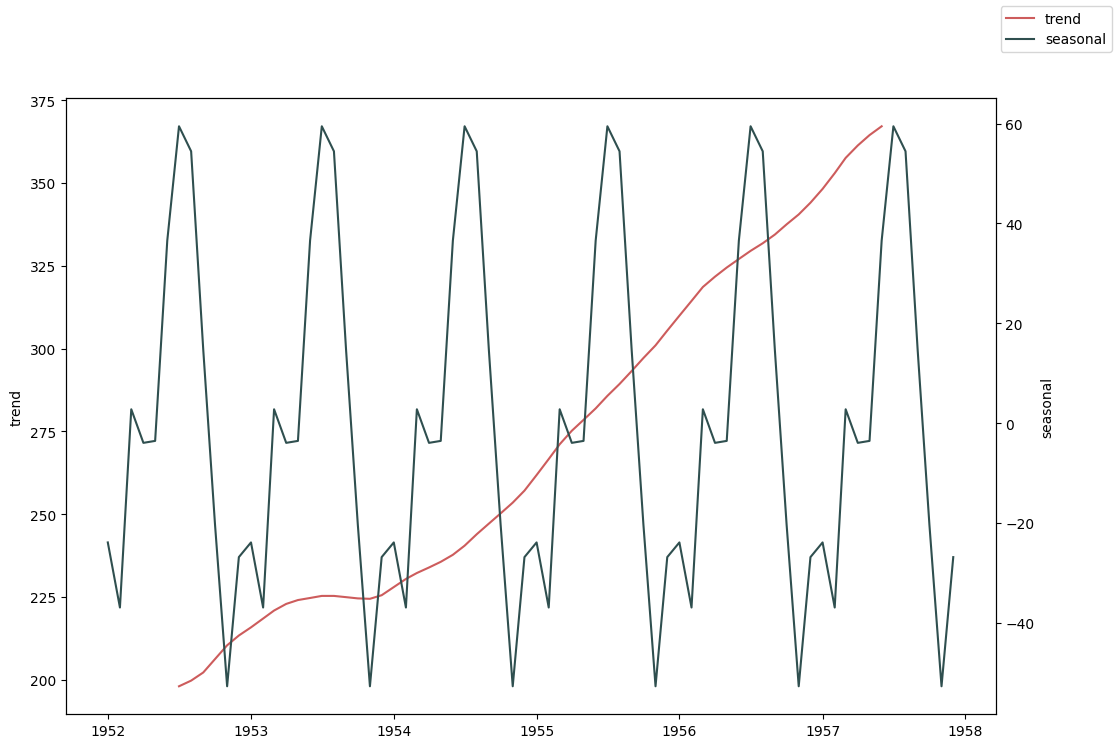

In [235]:
decomposed = seasonal_decompose(data_slice['#Passengers'])
trend = decomposed.trend
seasonal = decomposed.seasonal

fig, ax = plt.subplots(1, 1, figsize=[12, 8])

ax.plot(trend, c='indianred', label='trend')
ax.set_ylabel('trend')

ax2 = ax.twinx()
ax2.plot(seasonal, c='darkslategrey', label='seasonal')
ax2.set_ylabel('seasonal')

fig.legend()

**Задание 2b(i):**
Да, тренд наблюдается. с каждым годом он плавно растёт.  
  
**Задание 2b(ii):**
Да, есть наличие сезонности. Наблюдается ежегодная сеозонность.  
  
**Задание 2b(iii):**
Ряд не является стационарным, так как тут наблюдается тренд, из-за тренда распределение со временем меняется

### Задание 2c

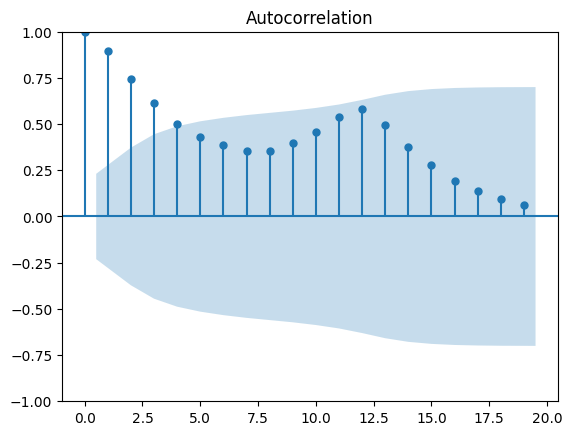

In [236]:
fig = tsaplots.plot_acf(data_slice['#Passengers'])
plt.show()

**Задание 2c(i):** Самая высокая автокорреляция у сдвига 1 месяц, не считая 0.  
     
**Задание 2c(ii):** Да, подтверждаются. Все значения автокорреляции являются в среднем положительными, следовательно есть наличие положительного тренда.

# Задание 3

### Задание 3a

In [237]:
def make_features(data, lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    
    for i in lag:
        data[f'lag_{i}'] = data['#Passengers'].shift(i)
    
    for m in rolling_mean_size:
        data['rolling_mean_{}'.format(m)] = data['#Passengers'].rolling(m).mean()
        data['rolling_mean_{}'.format(m)] = data['rolling_mean_{}'.format(m)].shift(1)
    
    return data

### Задание 3b

In [238]:
lags = range(1, 10, 1)
rolling_means = [3, 6, 8]

data_with_features = make_features(data_slice[['#Passengers']].copy(), lags, rolling_means)
data_with_features.sample(5)

,#Passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean_3,rolling_mean_6,rolling_mean_8
Month,,,,,,,,,,,,,,,,
1956-12-01,306,1956,12,4,271.00,306.00,355.00,405.00,413.00,374.00,318.00,313.00,317.00,310.67,354.00,344.38
1956-02-01,277,1956,2,1,284.00,278.00,237.00,274.00,312.00,347.00,364.00,315.00,270.00,266.33,288.67,301.38
1957-11-01,305,1957,11,4,347.00,404.00,467.00,465.00,422.00,355.00,348.00,356.00,301.00,406.00,410.00,395.50
1953-03-01,236,1953,3,1,196.00,196.00,194.00,172.00,191.00,209.00,242.00,230.00,218.00,195.33,193.00,203.75
1952-04-01,181,1952,4,2,193.00,180.00,171.00,NaN,NaN,NaN,NaN,NaN,NaN,181.33,NaN,NaN


### Задание 3c

In [239]:
data_with_features.dropna(inplace=True)
print(f'Всего пропусков: {data_with_features.isna().sum().sum()}')

Всего пропусков: 0


### Задание 3d

In [240]:
features = data_with_features.drop('#Passengers', axis=1)
target = data_with_features['#Passengers']

### Задание 3e

In [241]:
train_features, test_features, train_target, test_target = train_test_split(features, target, shuffle=False, test_size=0.2)

# Задание 4

### Задание 4a

In [242]:
model = LinearRegression()
model.fit(train_features, train_target)

train_pred = model.predict(train_features)
test_pred = model.predict(test_features)

### Задание 4b

In [243]:
print(f'Качество MAE на обучающей выборке: {mean_absolute_error(train_target, train_pred)}')
print(f'Качество MAE на тестовой выборке: {mean_absolute_error(test_target, test_pred)}')

Качество MAE на обучающей выборке: 12.825581081816054
Качество MAE на тестовой выборке: 17.917158686747335


### Задание 4c

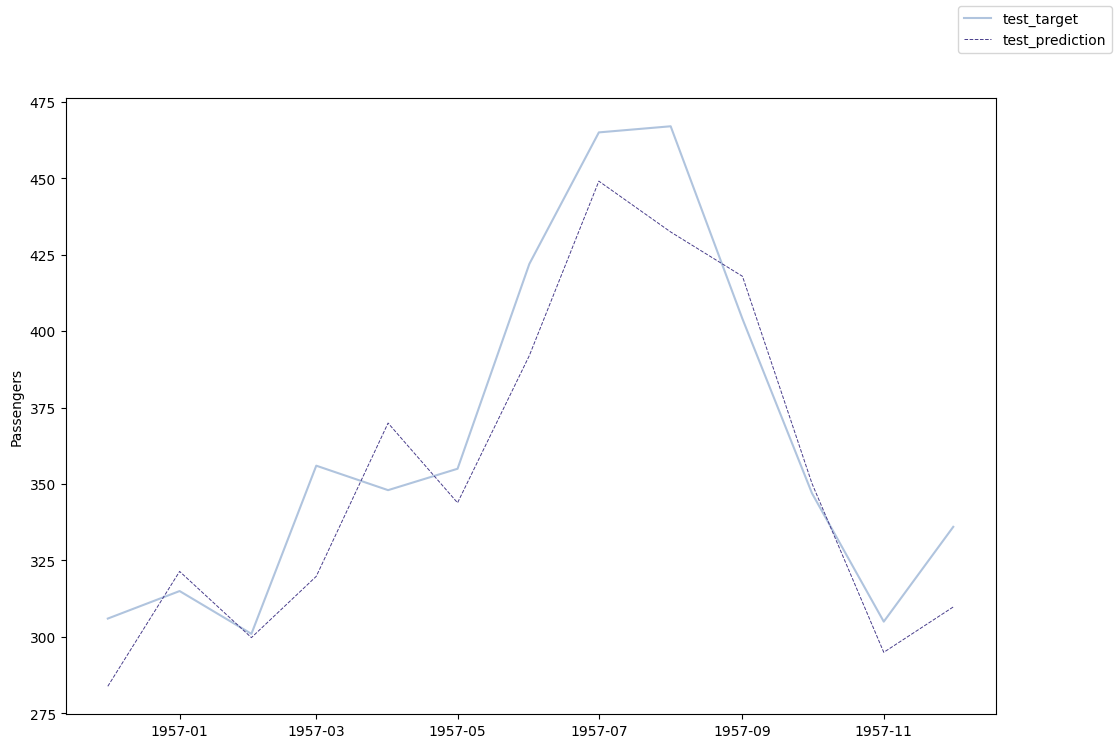

In [244]:
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

ax.plot(test_target, c='lightsteelblue', label='test_target')
ax.plot(pd.Series(test_pred, index=test_target.index), c='darkslateblue', label='test_prediction', linestyle='--', linewidth=0.7)
ax.set_ylabel('Passengers')
fig.legend()

# Задание 5

### Задание 5a

In [245]:
data_slice_new = data['1958':'1960']
print(data_slice_new.index.min(), data_slice_new.index.max())
print(data_slice_new.shape)

1958-01-01 00:00:00 1960-12-01 00:00:00
(36, 1)


### Задание 5b

In [246]:
# Долго думал, как исправить эту ситуацию, не получалось, в итоге про то, что нужно сначало сделать новые фичи и потом делать срез посмотрел в вебинаре и получилось

data_new = make_features(data[['#Passengers']].copy(), lags, rolling_means)
data_new = data_new['1958':'1960']
data_new.head(4)

,#Passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean_3,rolling_mean_6,rolling_mean_8
Month,,,,,,,,,,,,,,,,
1958-01-01,340,1958,1,1,336.00,305.00,347.00,404.00,467.00,465.00,422.00,355.00,348.00,329.33,387.33,387.62
1958-02-01,318,1958,2,1,340.00,336.00,305.00,347.00,404.00,467.00,465.00,422.00,355.00,327.00,366.50,385.75
1958-03-01,362,1958,3,1,318.00,340.00,336.00,305.00,347.00,404.00,467.00,465.00,422.00,331.33,341.67,372.75
1958-04-01,348,1958,4,2,362.00,318.00,340.00,336.00,305.00,347.00,404.00,467.00,465.00,340.00,334.67,359.88


In [247]:
data_new.dropna(inplace=True)
print(f'Всего пропусков: {data_new.isna().sum().sum()}')

Всего пропусков: 0


In [248]:
print(data_new.shape[0])

36


In [249]:
features_58_60 = data_new.drop('#Passengers', axis=1)
target_58_60 = data_new['#Passengers']

### Задание 5c

In [250]:
pred_new = model.predict(features_58_60)

### Задание 5d

In [251]:
print(f'Качество MAE на новой отложенной выборке: {mean_absolute_error(target_58_60, pred_new)}')

Качество MAE на новой отложенной выборке: 24.968236060120237


### Задание 5e

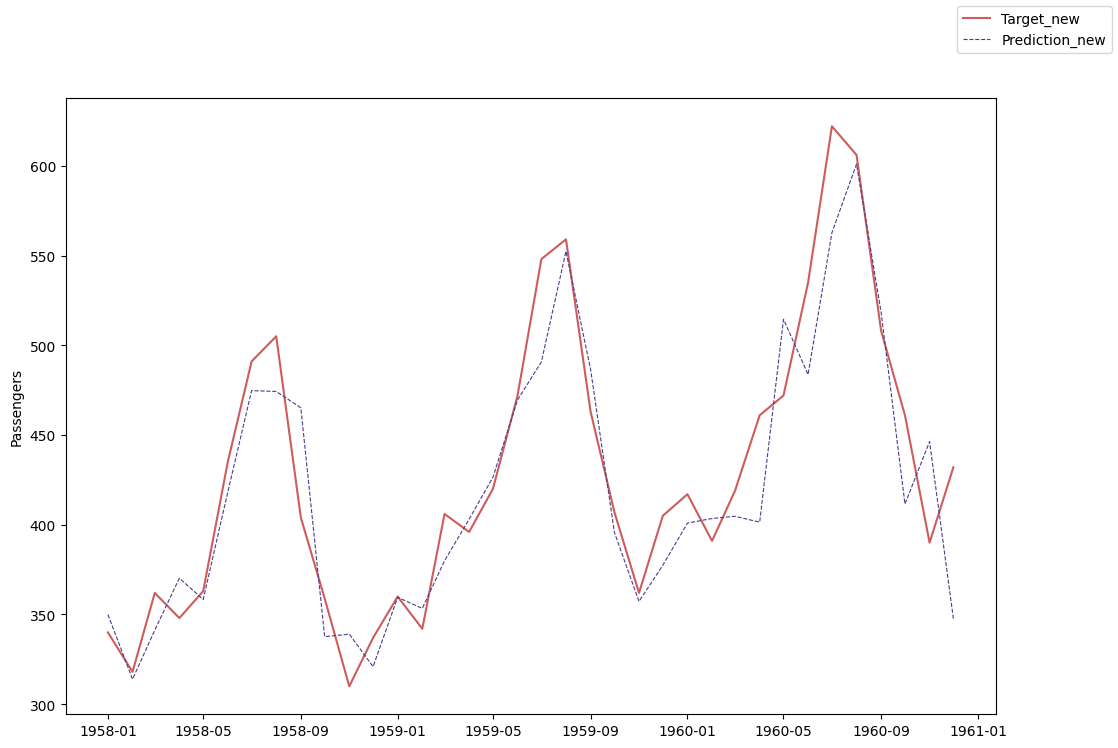

In [252]:
fig, ax = plt.subplots(1, 1, figsize=[12, 8])

ax.plot(target_58_60, c='indianred', label='Target_new')
ax.plot(pd.Series(pred_new, index=target_58_60.index), c='darkslateblue', label='Prediction_new', linestyle='--', linewidth=0.8)
ax.set_ylabel('Passengers')

fig.legend()

# Задание 6

**Вывод: обученная ранее модель показывает прогнозные значения с хорошей точностью, также значение метрики качества MAE довольно хорошие и не превышают значения 35, полученное значение составляет 24.968236060120237. В итоге мы попрактивались в анализе временных рядов, научились извлекать данные для того, чтобы прогнозировать временной ряд, и наша модель показывает хорошие результаты на метрике качества и на графике визуализации реального временного ряда и прогнозного значения с 1958 до 1960 видно, что модель хорошо прогнозирует.**